In [1]:
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory 
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------

# custom packages
import matplotlib.pyplot as plt
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import utils.configuration as cf
import utils.datasets as ud
import pandas as pd
from utils.visualise import visualize_layer_weights
from models.mnist_conv import mnist_conv
from models.aux_funs import net_sparsity

import numpy as np

# Fix the random seed

In [2]:
random_seed = 2
cf.seed_torch(random_seed)

# Configure the expirement

In [3]:
# weights_path = '../ProbMask/runs/mnist_conv_fashion_mnist-pr0.1/probmask/prune_rate=0.9/checkpoints/epoch_29.state'
weights_path = '../checkpoints/mnist_conv_sparse_linbreg_ggmodel_lambda_4.pth'
sparse_weights_path = weights_path
dense_weights_path = '../checkpoints/mnist_conv_dense.pth'
conf_args = {#
    # data specification
    'data_file':"../../Data",'train_split':0.95, 'data_set':"Fashion-MNIST", 'download':True,
    # cuda
    'use_cuda':False, 'num_workers':0, 'cuda_device':0, 'pin_memory':True,
    #
    'epochs':100,
    # optimizer
    'delta':1.0, 'lr':0.07, 'lamda_0':0.4, 'lamda_1':0.4, 'optim':"AdaBreg", 'conv_group':True,
    'beta':0.0,
    # initialization
    'sparse_init':0.01, 'r':[1,1,1],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
    'batch_size': 1000
}

conf = cf.Conf(**conf_args)

# Initiate model

In [4]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

model = mnist_conv(**model_kwargs).to(conf.device)

# Load model weights

In [5]:
def remove_module_prefix(state_dict):
    new_state_dict = {}
    for key in state_dict.keys():
        new_key = key.replace('module.', '')  # Remove the 'module.' prefix
        new_state_dict[new_key] = state_dict[key]
    return new_state_dict


model_weights = torch.load(weights_path, map_location=conf.device)
# model_weights = remove_module_prefix(model_weights['state_dict'])

# Apply the weights

model.load_state_dict(model_weights)

model

mnist_conv(
  (act_fn): ReLU()
  (layers1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (layers2): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

# Dataset

In [6]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

# Show the model works

In [7]:
train.test(conf, model, test_loader)

--------------------------------------------------
Test Accuracy: 0.8337


{'acc': 0.8337, 'loss': 4.6285044848918915}

In [8]:
net_sparsity(model)

0.018777078256160304

64


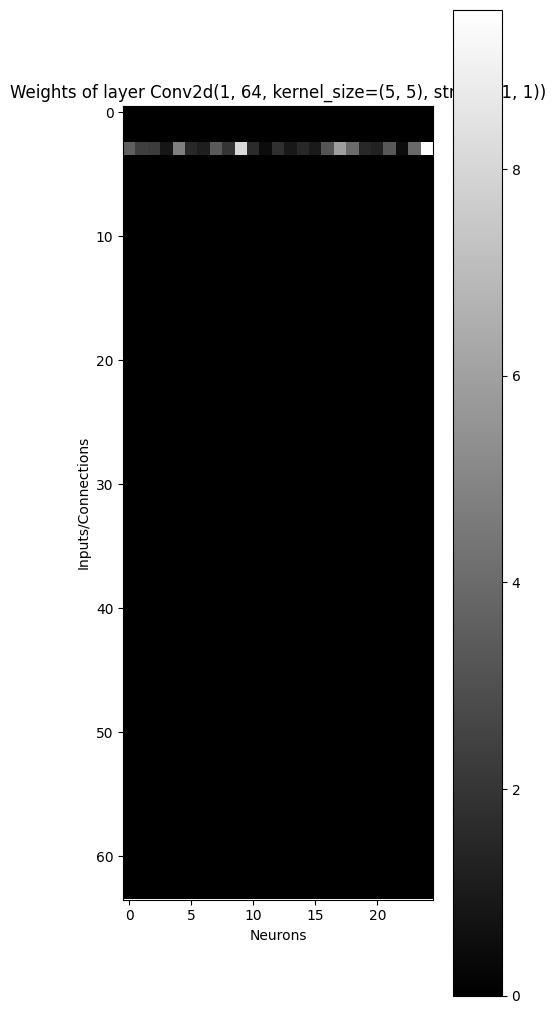

In [9]:

def visualize_layer_weights(layer):
    # Extracting the layer weights
    layer_weights = layer.weight.data
    layer_weights = layer_weights.view(layer_weights.shape[0], -1)

    # Converting the tensor to numpy for visualization
    layer_weights_np = layer_weights.cpu().numpy()
    print(len(layer_weights_np))

    layer_weights_np = np.abs(layer_weights_np)
    height, width = layer_weights_np.shape
    
#     layer_weights_np[np.where(layer_weights_np == 0)] = 1
    
#     print(np.count_nonzero(layer_weights_np == 1))
    plt.figure(figsize=(width * 20 / 100, height * 20 / 100))
    # Plotting the weights
    plt.imshow(layer_weights_np, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title(f"Weights of layer {layer}")
    plt.xlabel('Neurons')
    plt.ylabel('Inputs/Connections')
    plt.show()

    
visualize_layer_weights(model.layers1[0])

In [10]:

sparsities = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
for sparsity in sparsities:
    weights_path = f'../checkpoints/adabreg/mnist_conv_{sparsity}.pth'
    model_weights = torch.load(weights_path, map_location=conf.device)

    # Apply the weights
    model.eval()
    model.load_state_dict(model_weights)
    nsparsity = net_sparsity(model)

    print(f'Init sparsity: {sparsity} - Network sparsity: {nsparsity}')
    train.test(conf, model, test_loader)

Init sparsity: 0.01 - Network sparsity: 0.36891162334145683
--------------------------------------------------
Test Accuracy: 0.1
Init sparsity: 0.05 - Network sparsity: 0.4116191104792851
--------------------------------------------------
Test Accuracy: 0.8099
Init sparsity: 0.1 - Network sparsity: 0.42897881126455456
--------------------------------------------------
Test Accuracy: 0.8144
Init sparsity: 0.2 - Network sparsity: 0.466782595450853
--------------------------------------------------
Test Accuracy: 0.8046
Init sparsity: 0.5 - Network sparsity: 0.513120261305172
--------------------------------------------------
Test Accuracy: 0.7764
Init sparsity: 1 - Network sparsity: 0.6241495735174655
--------------------------------------------------
Test Accuracy: 0.7988


# Attack the Model

In [17]:
def bim_attack(model, data, target, eps, alpha, iters):
    # Copy the original images to avoid modifying them
    adv_images = data.clone().detach().requires_grad_(True)
    
    # Loop over the number of iterations
    for i in range(iters):
        # Requires gradient

        # Forward pass
        outputs = model(adv_images)

        model.zero_grad()

        # Calculate loss
        loss = F.cross_entropy(outputs, target)

        # Backward pass
        loss.backward()
        
        # Adversarial example update
        with torch.no_grad():
            grad = adv_images.grad
            if grad is None:
                print(f'grad is None at {i}')
                continue
                
            perturbation = alpha * grad.sign()
            adv_images = adv_images + perturbation
            perturbation = torch.clamp(adv_images - data, min=-eps, max=eps)
            adv_images = torch.clamp(data + perturbation, min=0, max=1)
            adv_images = adv_images.detach().requires_grad_(True)

    return adv_images.detach()

def get_batch(loader):
    for data, target in loader:
        return data, target
    
    
def test_bim(model, data, target, conf, epsilon, alpha):
    correct = 0
    adv_examples = []
    for x, y in zip(data, target):
        x, y = x.unsqueeze(0).to(conf.device), y.to(conf.device)
        output = model(x)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == y.item():
            correct += 1
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = x.squeeze().detach().cpu().numpy()
                adv_examples.append( (y.item(), final_pred.item(), adv_ex) )
        
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(data)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(conf.device)
    if isinstance(std, list):
        std = torch.tensor(std).to(conf.device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)


def test_fgm(model, test_loader, conf, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    x, y = get_batch(test_loader)
    for data, target in zip(x, y):

        # Send the data and label to the device
        data, target = data.unsqueeze(0).to(conf.device), target.unsqueeze(0).to(conf.device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue
            
        # Calculate the loss 
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


def load_model(conf, ppath):
    model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

    model = mnist_conv(**model_kwargs).to(conf.device)
    model_weights = torch.load(ppath, map_location=conf.device)

    model.load_state_dict(model_weights)

    return model


In [20]:
base_path = '../checkpoints' 

models = [('sparse 2%', 'redo_linbreg_2pc.pth'), 
          ('sparse 5%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_5_5pc.pth'),
          ('sparse 10%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_5_10pc.pth'),
          ('sparse 20%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_5_20pc.pth'),
          ('sparse 40%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_5_50pc.pth'),
          ('dense', 'mnist_conv_dense.pth' )]

for (name, path) in models:
    model = load_model(conf, f'{base_path}/{path}')

    nsparsity = net_sparsity(model)

    print(f'Init sparsity: {path} - Network sparsity: {nsparsity}')
    train.test(conf, model, test_loader)

Init sparsity: mnist_conv_sparse_linbreg_ggmodel_lambda_4.pth - Network sparsity: 0.018777078256160304
--------------------------------------------------
Test Accuracy: 0.8337
Init sparsity: mnist_conv_sparse_linbreg_ggmodel_lambda_5_5pc.pth - Network sparsity: 0.060287198754400216
--------------------------------------------------
Test Accuracy: 0.8629
Init sparsity: mnist_conv_sparse_linbreg_ggmodel_lambda_5_10pc.pth - Network sparsity: 0.10263082182507446
--------------------------------------------------
Test Accuracy: 0.8613
Init sparsity: mnist_conv_sparse_linbreg_ggmodel_lambda_5_20pc.pth - Network sparsity: 0.1829390062279989
--------------------------------------------------
Test Accuracy: 0.8813
Init sparsity: mnist_conv_sparse_linbreg_ggmodel_lambda_5_50pc.pth - Network sparsity: 0.42610174654752236
--------------------------------------------------
Test Accuracy: 0.8913
Init sparsity: mnist_conv_dense.pth - Network sparsity: 1.0
---------------------------------------------

In [12]:
base_path = '../checkpoints' 

models = [('sparse 2%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_4.pth'), 
          ('sparse 5%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_5_5pc.pth'),
          ('sparse 10%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_5_10pc.pth'),
          ('sparse 20%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_5_20pc.pth'),
          ('sparse 40%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_5_50pc.pth'),
          ('dense', 'mnist_conv_dense.pth' )]
alpha = .1
iters = 10
epsilons = np.arange(0, 0.104, 0.004)


accuracies = { 'sparse 2%': [], 'sparse 5%': [], 'sparse 10%': [], 'sparse 20%': [], 'sparse 40%':[], 'dense': []} 

examples = []

data, target = get_batch(test_loader)

for (name, path) in models:
    model = load_model(conf, f'{base_path}/{path}')
    for eps in epsilons:
        adv_examples = bim_attack(model, data, target, eps, alpha, iters)
        acc, ex = test_bim(model, adv_examples, target, conf, eps, alpha)
        accuracies[name].append(acc)
        examples = ex

Epsilon: 0.0	Test Accuracy = 852 / 1000 = 85.2


KeyboardInterrupt: 

In [17]:
data_dict = accuracies
data_dict['eps'] = epsilons.tolist()
df = pd.DataFrame(data_dict)
df.set_index('eps', inplace=True)
df.head(5)

,sparse 2%,sparse 5%,sparse 10%,sparse 20%,sparse 40%,dense
eps,,,,,,
0.000,85.2,87.2,86.6,88.8,90.0,90.7
0.004,80.5,81.9,79.3,83.1,84.9,87.7
0.008,77.2,75.7,73.8,78.2,79.1,79.8
0.012,73.5,70.6,68.8,71.2,73.1,74.1
0.016,71.1,65.1,61.9,66.1,66.8,68.6


In [18]:
df.to_csv('../results/dense_multi_sparse_BIM_attack.csv')

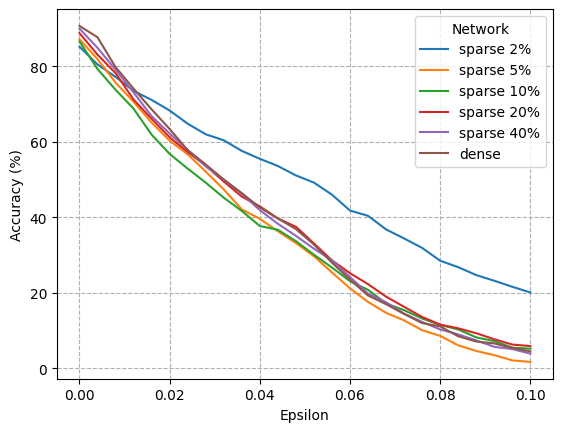

In [19]:
df = pd.read_csv('../results/dense_multi_sparse_BIM_attack.csv')
df.set_index('eps', inplace=True)

df.plot(kind='line')
plt.grid(True, linestyle='--')
plt.legend(title='Network')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.savefig('dense_sparse_BIM_attack.png')

# FGM Attack

In [89]:
x, y = get_batch(test_loader)


(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

In [21]:
base_path = '../checkpoints' 
models = [('sparse 2%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_4.pth'), 
          ('sparse 5%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_5_5pc.pth'),
          ('sparse 10%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_5_10pc.pth'),
          ('sparse 20%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_5_20pc.pth'),
          ('sparse 40%', 'mnist_conv_sparse_linbreg_ggmodel_lambda_5_50pc.pth'),
          ('dense', 'mnist_conv_dense.pth' )]
alpha = .1
iters = 10
epsilons = np.arange(0, 0.104, 0.004)


accuracies = { 'sparse 2%': [], 'sparse 5%': [], 'sparse 10%': [], 'sparse 20%': [], 'sparse 40%':[], 'dense': []} 

examples = []

for (name, path) in models:
    model = load_model(conf, f'{base_path}/{path}')
    for eps in epsilons:
        acc, ex = test_fgm(model, test_loader, conf, eps)
        accuracies[name].append(acc)
        examples = ex


Epsilon: 0.0	Test Accuracy = 852 / 10 = 85.2
Epsilon: 0.004	Test Accuracy = 758 / 10 = 75.8
Epsilon: 0.008	Test Accuracy = 673 / 10 = 67.3
Epsilon: 0.012	Test Accuracy = 584 / 10 = 58.4
Epsilon: 0.016	Test Accuracy = 513 / 10 = 51.3
Epsilon: 0.02	Test Accuracy = 459 / 10 = 45.9
Epsilon: 0.024	Test Accuracy = 401 / 10 = 40.1
Epsilon: 0.028	Test Accuracy = 367 / 10 = 36.7
Epsilon: 0.032	Test Accuracy = 334 / 10 = 33.4
Epsilon: 0.036000000000000004	Test Accuracy = 296 / 10 = 29.6
Epsilon: 0.04	Test Accuracy = 270 / 10 = 27.0
Epsilon: 0.044	Test Accuracy = 250 / 10 = 25.0
Epsilon: 0.048	Test Accuracy = 231 / 10 = 23.1
Epsilon: 0.052000000000000005	Test Accuracy = 213 / 10 = 21.3
Epsilon: 0.056	Test Accuracy = 197 / 10 = 19.7
Epsilon: 0.06	Test Accuracy = 181 / 10 = 18.1
Epsilon: 0.064	Test Accuracy = 172 / 10 = 17.2
Epsilon: 0.068	Test Accuracy = 157 / 10 = 15.7
Epsilon: 0.07200000000000001	Test Accuracy = 145 / 10 = 14.5
Epsilon: 0.076	Test Accuracy = 133 / 10 = 13.3
Epsilon: 0.08	Test Ac

In [22]:
data_dict = accuracies
data_dict['eps'] = epsilons.tolist()
df = pd.DataFrame(data_dict)
df.set_index('eps', inplace=True)
df.head(5)

,sparse 2%,sparse 5%,sparse 10%,sparse 20%,sparse 40%,dense
eps,,,,,,
0.000,85.2,87.2,86.6,88.8,90.0,90.7
0.004,75.8,72.7,70.1,73.1,74.5,75.7
0.008,67.3,60.4,54.1,59.0,60.8,60.8
0.012,58.4,48.1,43.0,47.0,47.1,47.4
0.016,51.3,38.3,36.2,36.9,36.2,36.8


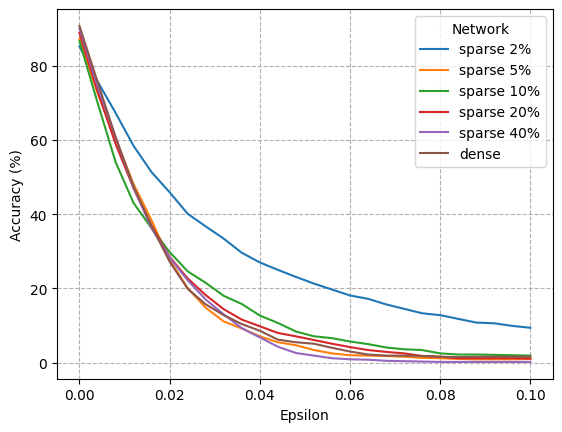

In [23]:
df.plot(kind='line')
plt.grid(True, linestyle='--')
plt.legend(title='Network')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.savefig('dense_multi_sparse_FGSM_attack.png')

In [24]:
df.to_csv('../results/dense_multi_sparse_FGSM_attack.csv')

In [25]:
df = pd.read_csv('../results/dense_multi_sparse_FGSM_attack.csv')
df.set_index('eps', inplace=True)
df

,sparse 2%,sparse 5%,sparse 10%,sparse 20%,sparse 40%,dense
eps,,,,,,
0.000,85.2,87.2,86.6,88.8,90.0,90.7
0.004,75.8,72.7,70.1,73.1,74.5,75.7
0.008,67.3,60.4,54.1,59.0,60.8,60.8
0.012,58.4,48.1,43.0,47.0,47.1,47.4
0.016,51.3,38.3,36.2,36.9,36.2,36.8
0.020,45.9,27.7,29.8,28.5,28.3,27.2
0.024,40.1,20.1,24.6,22.7,22.2,19.9
0.028,36.7,14.8,21.5,18.2,17.0,15.7
0.032,33.4,11.1,18.0,14.4,13.0,12.8


TypeError: cannot unpack non-iterable int object

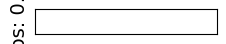

In [26]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(ex[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(ex[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()